<a href="https://colab.research.google.com/github/FeliGR/Madrid-Mortality-Forecast-Climate-Time-Series/blob/main/madrid_mortality_forecast_with_climate_exogenous_variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install skforecast
!pip install xgboost
!pip install pmdarima


# **1. Carga y Preparación de los Datos**
A continuación, cargamos los datos y verificamos la estructura, tipos de datos, y la existencia de valores faltantes.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet
from skforecast.model_selection import grid_search_forecaster
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.model_selection import backtesting_forecaster


In [ ]:
# Cargar los datos
defunciones_temperaturas_madrid_df = pd.read_csv('defunciones_temperaturas_madrid.csv')

In [ ]:
# Visualizar las primeras filas para verificar la estructura
print(defunciones_temperaturas_madrid_df.head())

        fecha  defunciones_corregidas  tavg  tmin  tmax
0  2015-01-01                  148.74   5.9  -1.0  10.4
1  2015-01-02                  159.11   7.6  -1.0  12.0
2  2015-01-03                  161.42   7.7   1.2  11.4
3  2015-01-04                  140.67  10.1   1.4  14.0
4  2015-01-05                  181.02   7.7   1.5  12.0


In [ ]:
# Verificar los tipos de datos
print(defunciones_temperaturas_madrid_df.dtypes)

fecha                      object
defunciones_corregidas    float64
tavg                      float64
tmin                      float64
tmax                      float64
dtype: object


In [ ]:
# Convertir la columna de fecha al formato datetime
defunciones_temperaturas_madrid_df['fecha'] = pd.to_datetime(defunciones_temperaturas_madrid_df['fecha'], errors='coerce')

# Establecer la columna de fecha como índice
defunciones_temperaturas_madrid_df.set_index('fecha', inplace=True)

defunciones_temperaturas_madrid_df = defunciones_temperaturas_madrid_df.asfreq('D')

In [ ]:
# Mostrar las primeras filas después del ajuste de fecha
print(defunciones_temperaturas_madrid_df.head())

            defunciones_corregidas  tavg  tmin  tmax
fecha                                               
2015-01-01                  148.74   5.9  -1.0  10.4
2015-01-02                  159.11   7.6  -1.0  12.0
2015-01-03                  161.42   7.7   1.2  11.4
2015-01-04                  140.67  10.1   1.4  14.0
2015-01-05                  181.02   7.7   1.5  12.0


In [ ]:
# Ver estadísticas descriptivas
print(defunciones_temperaturas_madrid_df.describe())

       defunciones_corregidas         tavg         tmin         tmax
count             3531.000000  3531.000000  3531.000000  3531.000000
mean               136.880949    16.257293    11.229708    21.464514
std                 51.089576     8.056835     6.769917     9.105693
min                 68.030000    -3.200000    -7.400000     0.300000
25%                116.450000     9.500000     5.600000    13.500000
50%                130.020000    15.100000    10.500000    20.300000
75%                146.270000    22.800000    16.700000    29.000000
max                817.270000    34.400000    26.200000    40.700000


In [ ]:
# Verificar si hay valores faltantes en el conjunto de datos
print(defunciones_temperaturas_madrid_df.isnull().sum())

defunciones_corregidas    0
tavg                      0
tmin                      0
tmax                      0
dtype: int64


---

# **2. Análisis Exploratorio de la Serie Temporal (Sin Variables Exógenas)**
En esta sección, se realiza la descomposición de la serie temporal de defunciones. Además, se calculan las funciones de autocorrelación y autocorrelación parcial, y se visualiza la media móvil de las defunciones.

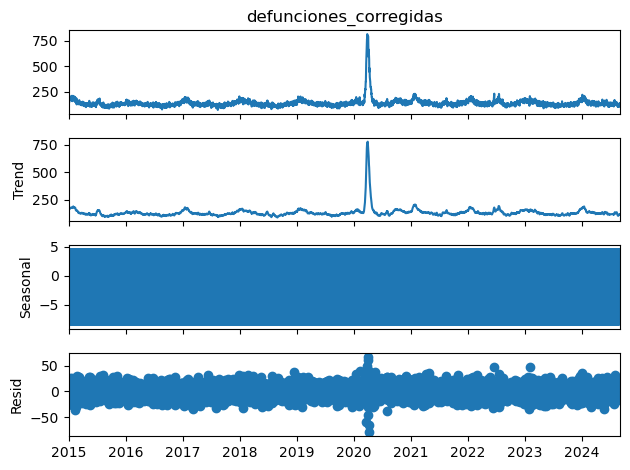

In [ ]:
# Descomposición de la serie temporal (solo defunciones)
decomposed_defunciones_sin_exogenas = sm.tsa.seasonal_decompose(defunciones_temperaturas_madrid_df['defunciones_corregidas'], model='additive')
decomposed_defunciones_sin_exogenas.plot()
plt.show()

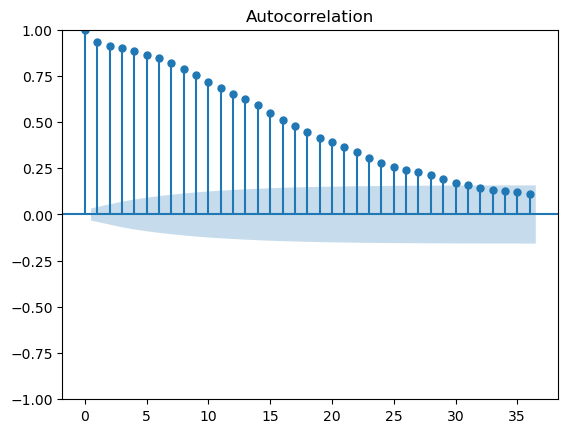

In [ ]:
# Graficar autocorrelación para la serie de defunciones corregidas (sin exógenas)
plot_acf(defunciones_temperaturas_madrid_df['defunciones_corregidas'])
plt.show()

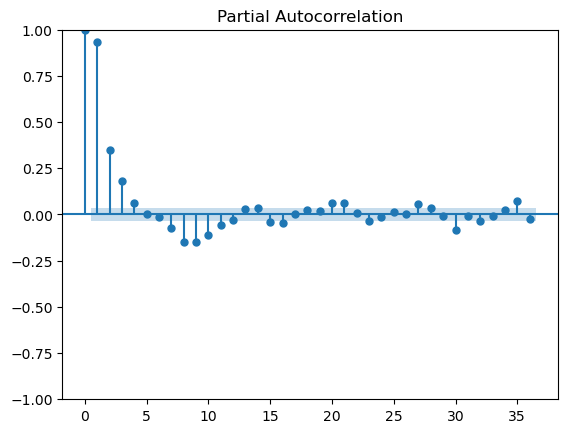

In [ ]:
# Graficar autocorrelación parcial para la serie de defunciones corregidas (sin exógenas)
plot_pacf(defunciones_temperaturas_madrid_df['defunciones_corregidas'])
plt.show()

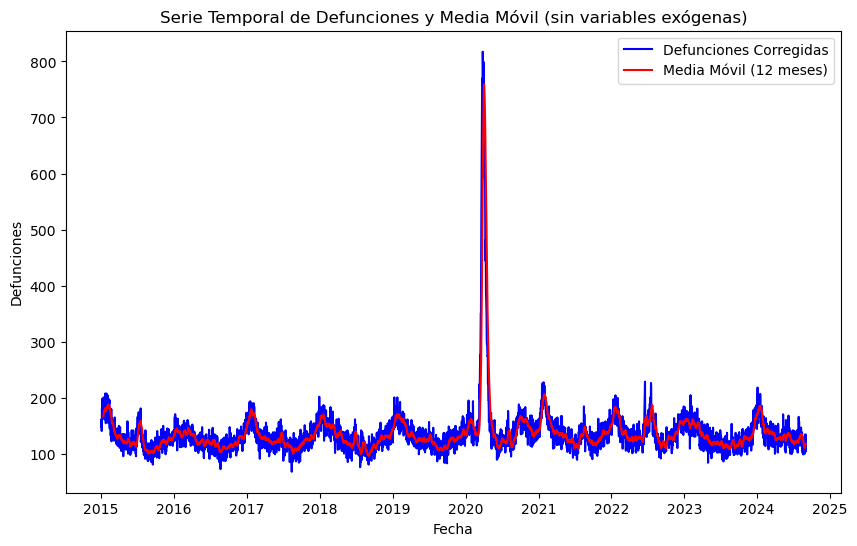

In [ ]:
# Calcular media móvil (solo defunciones)
defunciones_temperaturas_madrid_df['defunciones_rolling'] = defunciones_temperaturas_madrid_df['defunciones_corregidas'].rolling(window=12).mean()

# Graficar defunciones corregidas y su media móvil
plt.figure(figsize=(10, 6))
plt.plot(defunciones_temperaturas_madrid_df.index, defunciones_temperaturas_madrid_df['defunciones_corregidas'], label='Defunciones Corregidas', color='blue')
plt.plot(defunciones_temperaturas_madrid_df.index, defunciones_temperaturas_madrid_df['defunciones_rolling'], label='Media Móvil (12 meses)', color='red')
plt.title('Serie Temporal de Defunciones y Media Móvil (sin variables exógenas)')
plt.xlabel('Fecha')
plt.ylabel('Defunciones')
plt.legend()
plt.show()

---

# **3. Análisis Exploratorio de la Serie Temporal (Con Variables Exógenas)**
A continuación, se grafican las variables exógenas (temperaturas) y se calculan las autocorrelaciones y las correlaciones entre las variables.

In [ ]:
# Graficar las defunciones corregidas y temperaturas
plt.figure(figsize=(14, 7))

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

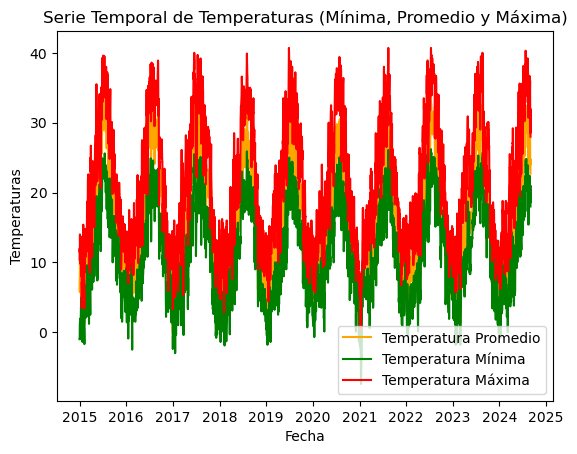

In [ ]:
# Graficar la temperatura promedio
plt.plot(defunciones_temperaturas_madrid_df.index, defunciones_temperaturas_madrid_df['tavg'], color='orange', label='Temperatura Promedio')
plt.plot(defunciones_temperaturas_madrid_df.index, defunciones_temperaturas_madrid_df['tmin'], color='green', label='Temperatura Mínima')
plt.plot(defunciones_temperaturas_madrid_df.index, defunciones_temperaturas_madrid_df['tmax'], color='red', label='Temperatura Máxima')

plt.title('Serie Temporal de Temperaturas (Mínima, Promedio y Máxima)')
plt.xlabel('Fecha')
plt.ylabel('Temperaturas')
plt.legend()
plt.show()

<Figure size 1000x600 with 0 Axes>

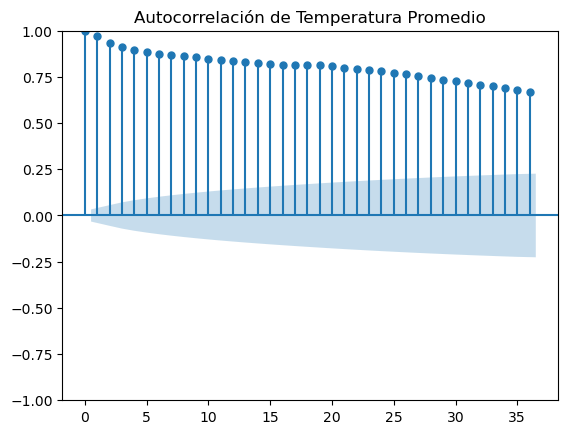

In [ ]:
# Graficar autocorrelación de la temperatura promedio
plt.figure(figsize=(10, 6))
plot_acf(defunciones_temperaturas_madrid_df['tavg'], title='Autocorrelación de Temperatura Promedio')
plt.show()

<Figure size 1000x600 with 0 Axes>

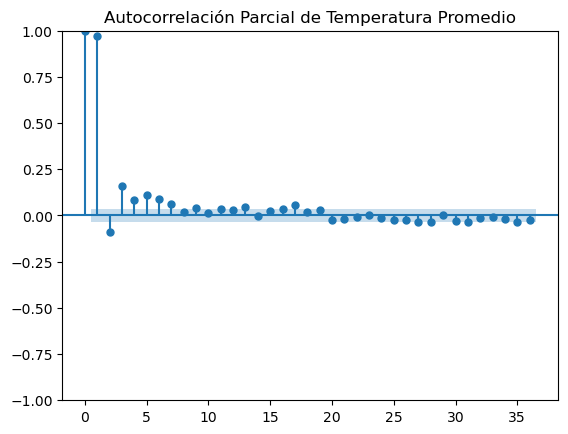

In [ ]:
# Autocorrelación parcial para la temperatura promedio
plt.figure(figsize=(10, 6))
plot_pacf(defunciones_temperaturas_madrid_df['tavg'], title='Autocorrelación Parcial de Temperatura Promedio')
plt.show()

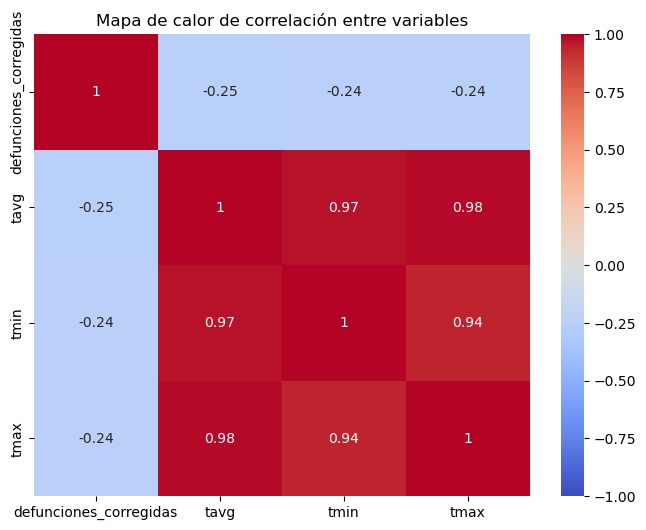

In [ ]:
# Calcular la matriz de correlación entre defunciones y temperaturas
correlation_matrix = defunciones_temperaturas_madrid_df[['defunciones_corregidas', 'tavg', 'tmin', 'tmax']].corr()

# Graficar el mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de calor de correlación entre variables')
plt.show()

---
# **4. Separación de Datos en Entrenamiento y Prueba (Sin Variables Exógenas)**
Dividimos los datos de **defunciones corregidas** en un 90% para el conjunto de **entrenamiento** y un 10% para el conjunto de **prueba** usando `train_test_split` de **sklearn**. No se utilizan variables exógenas en este paso, lo que significa que el modelo solo utilizará la serie de defunciones para hacer predicciones.

In [ ]:
# Re-muestrear las temperaturas a frecuencia semanal (variables exógenas)
exog_variables = defunciones_temperaturas_madrid_df[['tavg', 'tmin', 'tmax']].resample('W').mean()
defunciones_semanales_df = defunciones_temperaturas_madrid_df['defunciones_corregidas'].resample('W').sum()

# Separar en entrenamiento y prueba (manteniendo el 90% para entrenamiento y 10% para prueba)
y_train, y_test = train_test_split(defunciones_semanales_df, test_size=0.1, shuffle=False)
exog_train, exog_test = train_test_split(exog_variables, test_size=0.1, shuffle=False)

# Verificar que las variables exógenas y las series temporales estén alineadas
print(f"Fechas de entrenamiento (y_train): {y_train.index.min()} --- {y_train.index.max()}")
print(f"Fechas de entrenamiento (exog_train): {exog_train.index.min()} --- {exog_train.index.max()}")
print(f"Fechas de prueba (y_test): {y_test.index.min()} --- {y_test.index.max()}")
print(f"Fechas de prueba (exog_test): {exog_test.index.min()} --- {exog_test.index.max()}")


Fechas de entrenamiento (y_train): 2015-01-04 00:00:00 --- 2023-09-10 00:00:00
Fechas de entrenamiento (exog_train): 2015-01-04 00:00:00 --- 2023-09-10 00:00:00
Fechas de prueba (y_test): 2023-09-17 00:00:00 --- 2024-09-01 00:00:00
Fechas de prueba (exog_test): 2023-09-17 00:00:00 --- 2024-09-01 00:00:00


---
# **5. Modelos Descartados**
En esta sección se presentan los modelos descartados para los datos en frecuencia semanal debido a que su **mse** es superior al del mejor modelo seleccionado.

## 1. ForecasterAutoreg con RandomForestRegressor (Sin variables exógenas)

Error cuadrático medio: 10197.90034228432


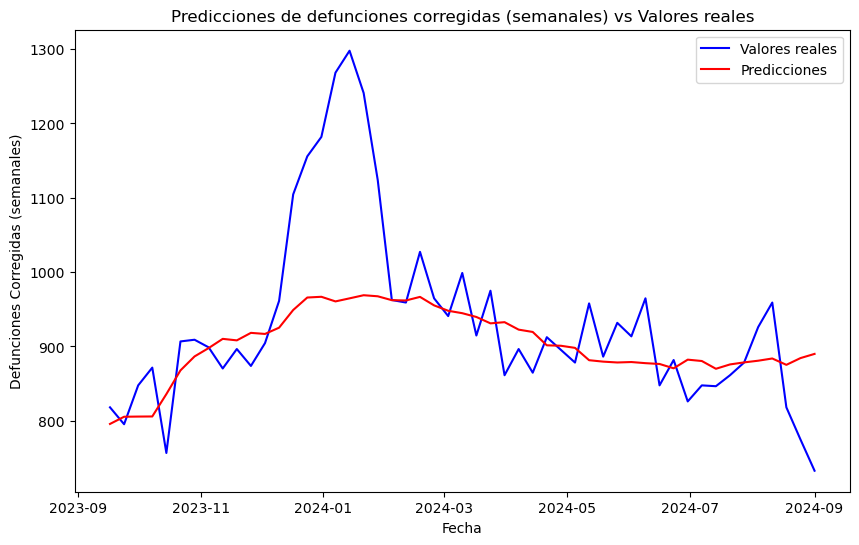

In [ ]:

# Crear el modelo ForecasterAutoreg con RandomForestRegressor
forecaster = ForecasterAutoreg(
    regressor = RandomForestRegressor(n_estimators=100, random_state=42),
    lags = 100
)

# Entrenar el modelo con los datos de entrenamiento
forecaster.fit(y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = forecaster.predict(steps=len(y_test))

# Evaluar el modelo utilizando el error cuadrático medio (MSE)
error_mse = mean_squared_error(y_test, y_pred)
print(f'Error cuadrático medio: {error_mse}')


# Graficar las predicciones frente a los valores reales
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valores reales', color='blue')
plt.plot(y_test.index, y_pred, label='Predicciones', color='red')
plt.title('Predicciones de defunciones corregidas (semanales) vs Valores reales')
plt.xlabel('Fecha')
plt.ylabel('Defunciones Corregidas (semanales)')
plt.legend()
plt.show()


## 2. ForecasterAutoreg con RandomForestRegressor (Con variables exógenas)

Error cuadrático medio con variables exógenas: 5064.583246777858


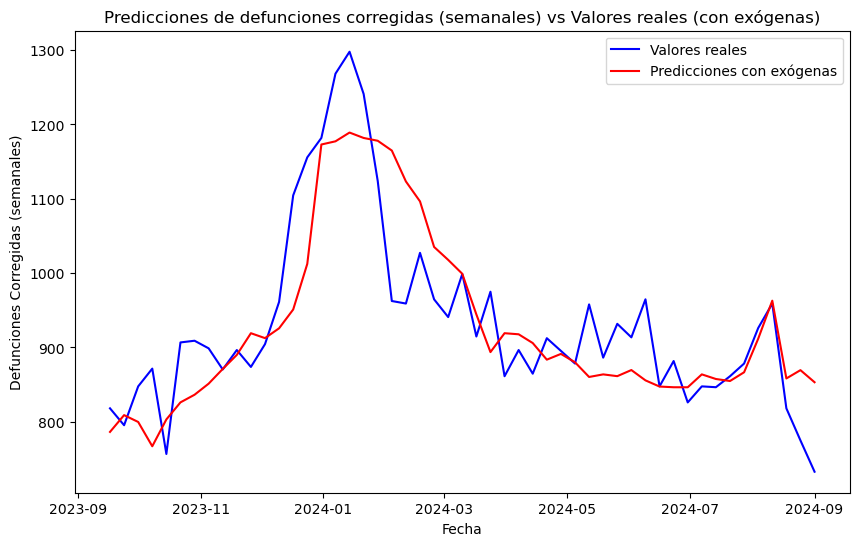

In [ ]:
# Crear el modelo ForecasterAutoreg con RandomForestRegressor con variables exógenas
forecaster = ForecasterAutoreg(
    regressor = RandomForestRegressor(n_estimators=100, random_state=42),
    lags = 17
)

# Entrenar el modelo con los datos de entrenamiento y variables exógenas
forecaster.fit(y=y_train, exog=exog_train)

# Hacer predicciones en el conjunto de prueba utilizando las variables exógenas
y_pred = forecaster.predict(steps=len(y_test), exog=exog_test)

# Evaluar el modelo utilizando el error cuadrático medio (MSE)
error_mse = mean_squared_error(y_test, y_pred)
print(f'Error cuadrático medio con variables exógenas: {error_mse}')

# Graficar las predicciones frente a los valores reales
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valores reales', color='blue')
plt.plot(y_test.index, y_pred, label='Predicciones con exógenas', color='red')
plt.title('Predicciones de defunciones corregidas (semanales) vs Valores reales (con exógenas)')
plt.xlabel('Fecha')
plt.ylabel('Defunciones Corregidas (semanales)')
plt.legend()
plt.show()

## 3. ForecasterAutoreg con XGBoost (Sin variables exógenas)

Error cuadrático medio sin variables exógenas: 10915.934136808733


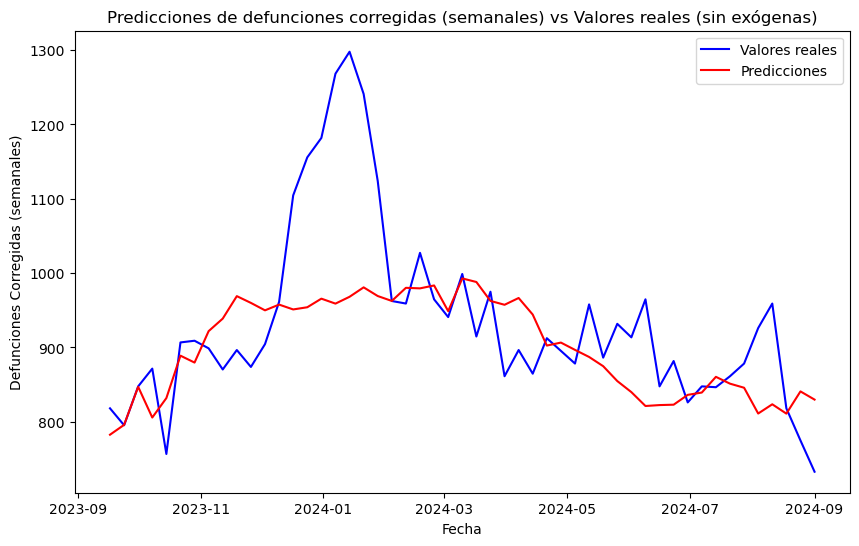

In [ ]:
# Crear el modelo ForecasterAutoreg con XGBoost
forecaster_sin_exog = ForecasterAutoreg(
    regressor = XGBRegressor(n_estimators=100, random_state=42),
    lags = 100
)

# Entrenar el modelo con los datos de entrenamiento 
forecaster_sin_exog.fit(y=y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_sin_exog = forecaster_sin_exog.predict(steps=len(y_test))

# Evaluar el modelo utilizando el error cuadrático medio (MSE)
error_mse_sin_exog = mean_squared_error(y_test, y_pred_sin_exog)
print(f'Error cuadrático medio sin variables exógenas: {error_mse_sin_exog}')

# Graficar las predicciones frente a los valores reales
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valores reales', color='blue')
plt.plot(y_test.index, y_pred_sin_exog, label='Predicciones', color='red')
plt.title('Predicciones de defunciones corregidas (semanales) vs Valores reales (sin exógenas)')
plt.xlabel('Fecha')
plt.ylabel('Defunciones Corregidas (semanales)')
plt.legend()
plt.show()


## 4. ForecasterAutoreg con XGBoost (Con variables exógenas)

Error cuadrático medio con variables exógenas: 4736.454773661031


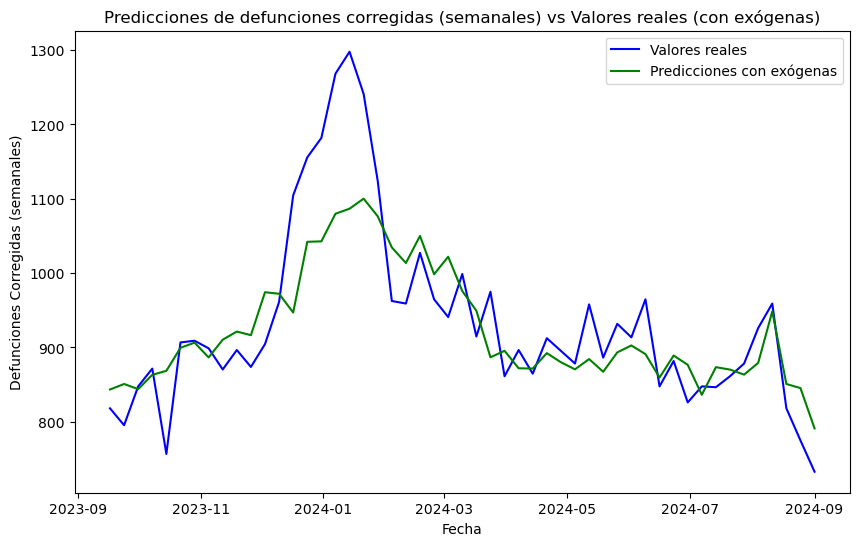

In [ ]:
# Crear el modelo ForecasterAutoreg con XGBoost con variables exógenas
forecaster_con_exog = ForecasterAutoreg(
    regressor = XGBRegressor(n_estimators=100, random_state=42),
    lags = 3  
)

# Entrenar el modelo con los datos de entrenamiento y variables exógenas
forecaster_con_exog.fit(y=y_train, exog=exog_train)

# Hacer predicciones en el conjunto de prueba utilizando las variables exógenas
y_pred_con_exog = forecaster_con_exog.predict(steps=len(y_test), exog=exog_test)

# Evaluar el modelo utilizando el error cuadrático medio (MSE)
error_mse_con_exog = mean_squared_error(y_test, y_pred_con_exog)
print(f'Error cuadrático medio con variables exógenas: {error_mse_con_exog}')

# Graficar las predicciones frente a los valores reales
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valores reales', color='blue')
plt.plot(y_test.index, y_pred_con_exog, label='Predicciones con exógenas', color='green')
plt.title('Predicciones de defunciones corregidas (semanales) vs Valores reales (con exógenas)')
plt.xlabel('Fecha')
plt.ylabel('Defunciones Corregidas (semanales)')
plt.legend()
plt.show()

## 5. ForecasterAutoreg con ElasticNet (Sin variables exógenas)

Error cuadrático medio sin variables exógenas: 13454.081788557083


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.610e+05, tolerance: 5.603e+03
  model = cd_fast.enet_coordinate_descent(


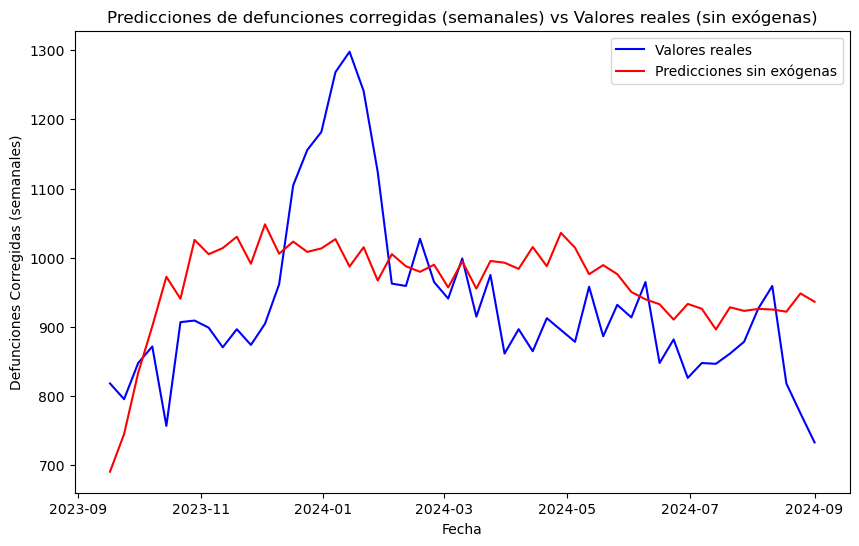

In [ ]:

# Crear el modelo ForecasterAutoreg con ElasticNet
forecaster_sin_exog = ForecasterAutoreg(
    regressor = ElasticNet(alpha=0.1, l1_ratio=0.5),
    lags = 100 
)

# Entrenar el modelo con los datos de entrenamiento 
forecaster_sin_exog.fit(y=y_train)

# Hacer predicciones en el conjunto de prueba 
y_pred_sin_exog = forecaster_sin_exog.predict(steps=len(y_test))

# Evaluar el modelo utilizando el error cuadrático medio (MSE)
error_mse_sin_exog = mean_squared_error(y_test, y_pred_sin_exog)
print(f'Error cuadrático medio sin variables exógenas: {error_mse_sin_exog}')

# Graficar las predicciones frente a los valores reales
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valores reales', color='blue')
plt.plot(y_test.index, y_pred_sin_exog, label='Predicciones sin exógenas', color='red')
plt.title('Predicciones de defunciones corregidas (semanales) vs Valores reales (sin exógenas)')
plt.xlabel('Fecha')
plt.ylabel('Defunciones Corregidas (semanales)')
plt.legend()
plt.show()

## 6. ForecasterAutoreg con ElasticNet (Con variables exógenas)

Error cuadrático medio con variables exógenas: 10393.871209946685


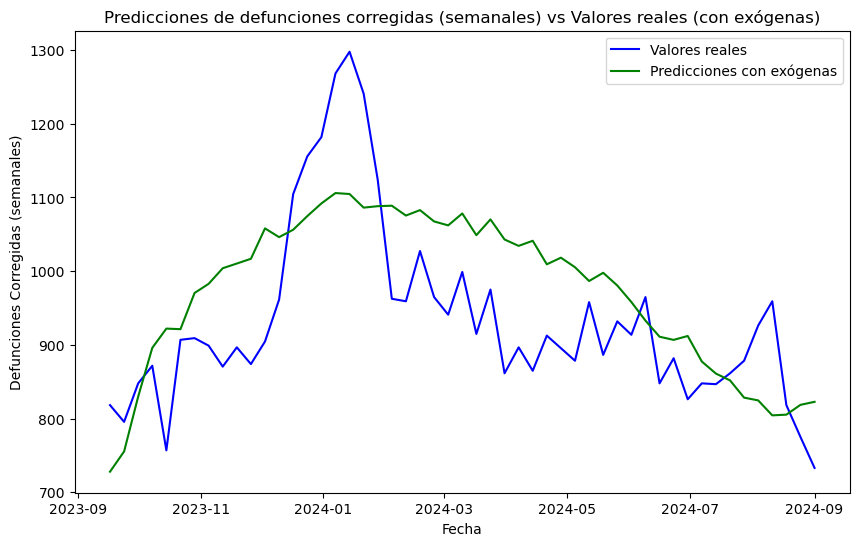

In [ ]:
# Crear el modelo ForecasterAutoreg con ElasticNet con variables exógenas
forecaster_con_exog = ForecasterAutoreg(
    regressor = ElasticNet(alpha=0.1, l1_ratio=0.5),
    lags = 60 
)

# Entrenar el modelo con los datos de entrenamiento y variables exógenas
forecaster_con_exog.fit(y=y_train, exog=exog_train)

# Hacer predicciones en el conjunto de prueba utilizando las variables exógenas
y_pred_con_exog = forecaster_con_exog.predict(steps=len(y_test), exog=exog_test)

# Evaluar el modelo utilizando el error cuadrático medio (MSE)
error_mse_con_exog = mean_squared_error(y_test, y_pred_con_exog)
print(f'Error cuadrático medio con variables exógenas: {error_mse_con_exog}')

# Graficar las predicciones frente a los valores reales
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valores reales', color='blue')
plt.plot(y_test.index, y_pred_con_exog, label='Predicciones con exógenas', color='green')
plt.title('Predicciones de defunciones corregidas (semanales) vs Valores reales (con exógenas)')
plt.xlabel('Fecha')
plt.ylabel('Defunciones Corregidas (semanales)')
plt.legend()
plt.show()


## 7. ForecasterAutoreg con DecisionTreeRegressor (Sin variables exógenas)

Error cuadrático medio sin variables exógenas: 8746.116702836998


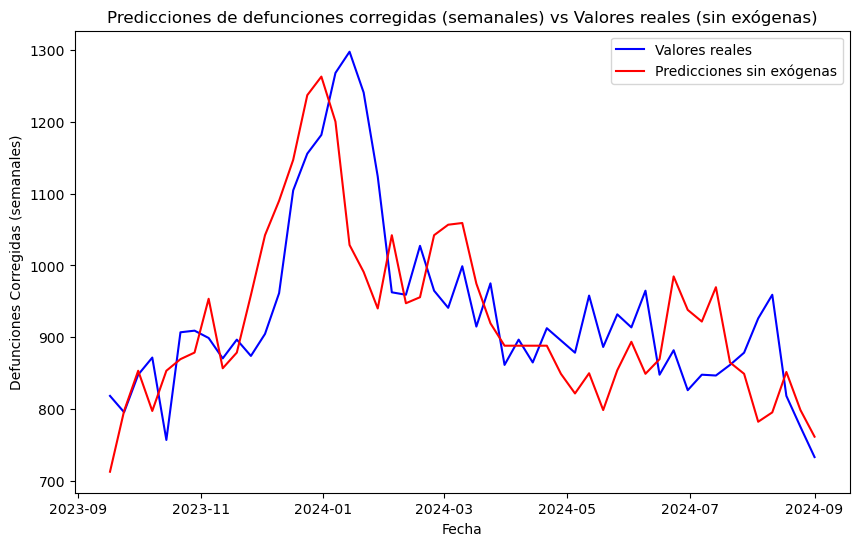

In [ ]:
# Crear el modelo ForecasterAutoreg con DecisionTreeRegressor
forecaster_sin_exog = ForecasterAutoreg(
    regressor = DecisionTreeRegressor(max_depth=10, random_state=42), 
    lags = 60 
)

# Entrenar el modelo con los datos de entrenamiento
forecaster_sin_exog.fit(y=y_train)

# Hacer predicciones en el conjunto de prueba 
y_pred_sin_exog = forecaster_sin_exog.predict(steps=len(y_test))

# Evaluar el modelo utilizando el error cuadrático medio (MSE)
error_mse_sin_exog = mean_squared_error(y_test, y_pred_sin_exog)
print(f'Error cuadrático medio sin variables exógenas: {error_mse_sin_exog}')

# Graficar las predicciones frente a los valores reales
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valores reales', color='blue')
plt.plot(y_test.index, y_pred_sin_exog, label='Predicciones sin exógenas', color='red')
plt.title('Predicciones de defunciones corregidas (semanales) vs Valores reales (sin exógenas)')
plt.xlabel('Fecha')
plt.ylabel('Defunciones Corregidas (semanales)')
plt.legend()
plt.show()


## 8. ForecasterAutoreg con DecisionTreeRegressor (Con variables exógenas)

Error cuadrático medio con variables exógenas: 5759.864283156753


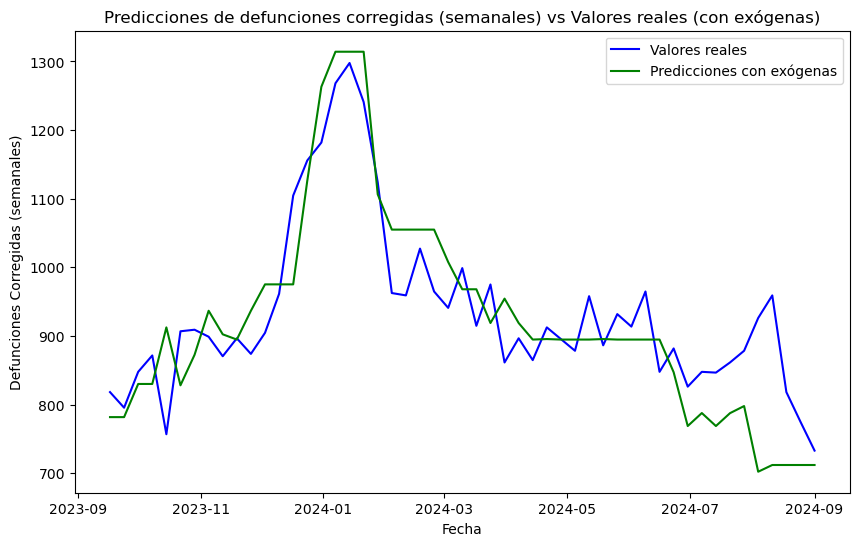

In [ ]:
# Crear el modelo ForecasterAutoreg con DecisionTreeRegressor con variables exógenas
forecaster_con_exog = ForecasterAutoreg(
    regressor = DecisionTreeRegressor(max_depth=10, random_state=42),
    lags = 130 
)

# Entrenar el modelo con los datos de entrenamiento y variables exógenas
forecaster_con_exog.fit(y=y_train, exog=exog_train)

# Hacer predicciones en el conjunto de prueba utilizando las variables exógenas
y_pred_con_exog = forecaster_con_exog.predict(steps=len(y_test), exog=exog_test)

# Evaluar el modelo utilizando el error cuadrático medio (MSE)
error_mse_con_exog = mean_squared_error(y_test, y_pred_con_exog)
print(f'Error cuadrático medio con variables exógenas: {error_mse_con_exog}')

# Graficar las predicciones frente a los valores reales
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valores reales', color='blue')
plt.plot(y_test.index, y_pred_con_exog, label='Predicciones con exógenas', color='green')
plt.title('Predicciones de defunciones corregidas (semanales) vs Valores reales (con exógenas)')
plt.xlabel('Fecha')
plt.ylabel('Defunciones Corregidas (semanales)')
plt.legend()
plt.show()


## 9. ForecasterAutoreg con ARIMA (Con variables exógenas)

In [ ]:
# Se hace esto para comprobar la estacionariedad de la serie
result = adfuller(defunciones_semanales_df)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -8.06488139091802
p-value: 1.6062170164864092e-12


Como obtenemos un resultado bajo (<0.05) sabemos que la serie es estacionaria

In [ ]:
# Ajustar el modelo ARIMA
p = 5
d = 1
q = 0
model = ARIMA(endog=y_train, exog=exog_train, order=(p, d, q))
model_fit = model.fit()

# Ver el resumen del modelo ajustado
print(model_fit.summary())

                                 SARIMAX Results                                  
Dep. Variable:     defunciones_corregidas   No. Observations:                  454
Model:                     ARIMA(5, 1, 0)   Log Likelihood               -2879.154
Date:                    Fri, 11 Oct 2024   AIC                           5776.309
Time:                            13:05:51   BIC                           5813.352
Sample:                        01-04-2015   HQIC                          5790.905
                             - 09-10-2023                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tavg          -6.5748     16.644     -0.395      0.693     -39.196      26.046
tmin           6.5078      7.306      0.891      0.373      -7.811      20.827
tmax           5.339

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Ajustar automáticamente los parámetros del modelo ARIMAX con mejoras
model = pm.auto_arima(y_train,
                      exogenous=exog_train,        # Variables exógenas
                      start_p=0, start_q=0,                  
                      max_p=10, max_q=00,                    
                      start_P=0, start_Q=0,                  
                      max_P=5, max_Q=5,                      
                      seasonal=True,                         # Activar la parte estacional
                      m=52,                                  # Número de períodos en una temporada (anual)
                      d=None,                                
                      D=None,                                
                      trace=True,                            
                      error_action='ignore',                 
                      suppress_warnings=True,                
                      stepwise=True,                         # Activar búsqueda paso a paso para búsqueda exhaustiva
                      maxiter=100,                           
                      information_criterion='aic')           # Usar AIC para mejorar la selección de modelos

# Ver el resumen del modelo ajustado
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=6634.357, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=5973.617, Time=1.38 sec
 ARIMA(0,0,0)(0,0,1)[52] intercept   : AIC=6634.893, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=7584.792, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=5972.083, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=5973.576, Time=1.71 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=5975.575, Time=2.54 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=5769.270, Time=0.08 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=5768.964, Time=5.25 sec
 ARIMA(2,0,0)(2,0,0)[52] intercept   : AIC=5771.160, Time=22.27 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=5771.034, Time=3.38 sec
 ARIMA(2,0,0)(0,0,1)[52] intercept   : AIC=5769.015, Time=3.06 sec
 ARIMA(2,0,0)(2,0,1)[52] intercept   : AIC=5772.963, Time=26.72 sec
 ARIMA(3,0,0)(1,0,0)[52] intercept   : AIC=5749.031, Time=4.53 sec
 ARIMA(3,0,0)(0,0

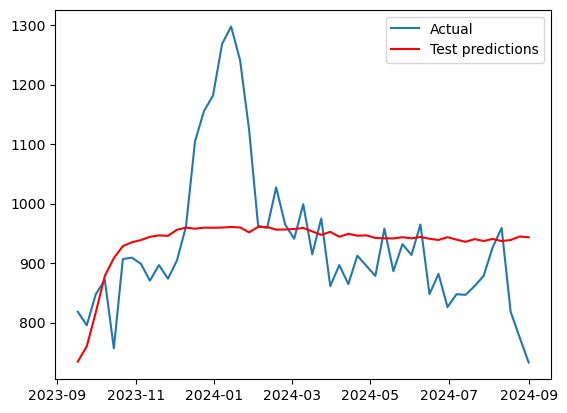

Mean Squared Error: 12881.397750989463


In [ ]:
# Predicciones en conjunto de prueba
predicciones_arimax = model.predict(n_periods=len(y_test), exogenous=exog_test)
plt.plot(y_test, label='Actual')
plt.plot(predicciones_arimax, label='Test predictions', color='red')
plt.legend()
plt.show()
mse = mean_squared_error(y_test, predicciones_arimax)
print(f'Mean Squared Error: {mse}')

## 10. ForecasterAutoreg con KNN (Con variables exógenas)

Para este modelo se han añadido más experimentos ya que se han querido probar, a parte de en el mejor modelo, en algún modelo con buen rendimiento que no estuviese basado en árboles. Igualmente los resultados obtenidos no son tan buenos como los obtenidos para el mejor modelo (GradientBoostingRegressor).

Error de test (mse) 5756.753949568626


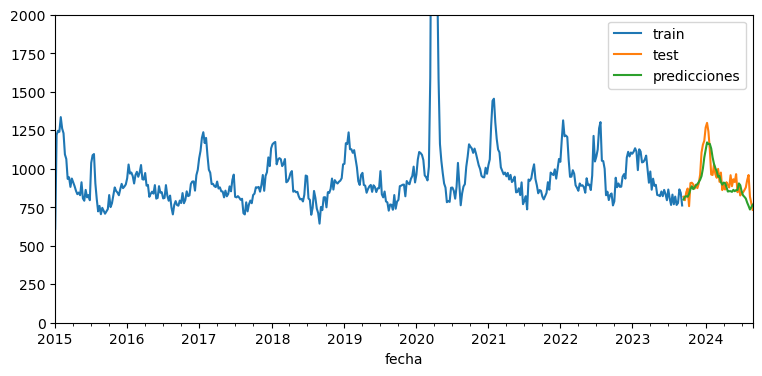

In [ ]:
# Definir el forecaster con el modelo base KNeighborsRegressor con variables exógenas
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = KNeighborsRegressor(n_neighbors=5),
                lags      = 40,
             )

forecaster.fit(y=y_train, exog=exog_train)
forecaster
# Predicciones
# ==============================================================================
predicciones_knn = forecaster.predict(steps=len(y_test), exog=exog_test)

# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
y_train.plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
predicciones_knn.plot(ax=ax, label='predicciones')
ax.legend();
ax.set_ylim(0, 2000)

# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_test,
                y_pred = predicciones_knn
            )

print(f"Error de test (mse) {error_mse}")

## 10.1. GridSearch KNN con Variables Exógenas

In [ ]:
# Definir el forecaster con el modelo base KNeighborsRegressor con variables exógenas
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = KNeighborsRegressor(metric='manhattan', n_neighbors=50, p=1, weights='uniform'),
                lags      = 40
             )

# Definir el espacio de búsqueda de hiperparámetros y lags
param_grid = {
    'n_neighbors': [5, 30],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'manhattan'],
    'p': [2, 1],
    'algorithm': ['auto', 'ball_tree', 'brute']
}

# Espacio de búsqueda para los lags
lags_grid = [20, 30,40, 50, 60, 70, 80, 90, 100, 110, 120, 130]

# Realizar el GridSearch para encontrar los mejores parámetros y lags
resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = defunciones_semanales_df,
                        exog               = exog_variables,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = len(y_test),
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(defunciones_semanales_df)*0.9),  # Tamaño del conjunto de entrenamiento
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                    )

# Mostrar los mejores parámetros y el error correspondiente
# Imprimir el resultado completo para ver su estructura
print(resultados_grid)

Number of models compared: 576.


lags grid:   0%|          | 0/12 [00:00<?, ?it/s]

params grid:   0%|          | 0/48 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] 
  Parameters: {'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
  Backtesting metric: 5169.494705928325

                                                  lags  \
115  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
99   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
121  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
105  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
123  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
..                                                 ...   
155  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
163  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
169  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
147  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 

In [ ]:
# Definir el forecaster con el modelo con los mejores parámetros KNeighborsRegressor
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = KNeighborsRegressor(algorithm = 'auto',metric='manhattan', n_neighbors=5,p=2, weights='distance' ),
                lags      = 40,
             )
forecaster.fit(y=y_train, exog=exog_train)
forecaster
# Predicciones
# ==============================================================================
predicciones_knn = forecaster.predict(steps=len(y_test), exog=exog_test)

# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
y_train.plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
predicciones_knn.plot(ax=ax, label='predicciones')
ax.legend();
ax.set_ylim(0, 2000)
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_test,
                y_pred = predicciones_knn
            )

print(f"Error de test (mse) {error_mse}")

## 10.2. Añadir predictores para KNN

In [ ]:
# Función para calcular los predictores a partir de la serie temporal
# ==============================================================================
from sklearn.linear_model import LinearRegression
def custom_predictors(y):
    '''
    # Desviación estándar con ventana de 2
    #std_2 = np.std(y[-2:])

    # Captura patrones anuales
    sin_year = np.sin(2 * np.pi * t / 52)  
    cos_year = np.cos(2 * np.pi * t / 52)

    # Frecuencia semestral 
    sin_halfyear = np.sin(2 * np.pi * t / 26)
    cos_halfyear = np.cos(2 * np.pi * t / 26)

    # Frecuencia trimestral
    sin_quarteryear = np.sin(2 * np.pi * t / 13)
    cos_quarteryear = np.cos(2 * np.pi * t / 13)
    '''
    lags = y[-1:-11:-1]
    # Media móvil con ventana de 3 semanas
    mean_20 = np.mean(y[-3:])

    # Diferencia del valor de la última semana y la de hace un año
    diff_1 = y[-1] - y[-52]
    diff_2 = y[-1] - 2 * y[-2] + y[-3]

    # Tendencia ajustada (Regresión lineal sobre últimas 3 semanas)
    t = np.arange(len(y[-3:])).reshape(-1, 1)
    model = LinearRegression().fit(t, y[-3:])
    trend = model.coef_[0]

    # Unir todos los predictores
    predictors = np.hstack([lags, mean_20, diff_1, diff_2, trend])
    return predictors



In [ ]:
# Definir el forecaster con KNeighborsRegressor
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                regressor      = KNeighborsRegressor(algorithm = 'auto',metric='manhattan', n_neighbors=5,p=2, weights='distance' ),
                fun_predictors = custom_predictors,
                window_size    = 52
             )

forecaster.fit(y=y_train,exog=exog_train)
forecaster

# Predicciones
# ==============================================================================
predicciones_endog = forecaster.predict(steps=len(y_test), exog=exog_test)

# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
y_train.plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
predicciones_endog.plot(ax=ax, label='predicciones')
ax.legend();
ax.set_ylim(0, 2000)
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_test,
                y_pred = predicciones_endog
            )

print(f"Error de test (mse) {error_mse}")

## 10.3. Backtesting para KNN

In [ ]:
# Definir el forecaster con el modelo con mejores parámetros de KNeighborsRegressor
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = KNeighborsRegressor(algorithm = 'auto',metric='manhattan', n_neighbors=5,p=2, weights='distance' ),
                lags      = 40,
             )
steps = 4
n_backtesting = 52 # Se separan para el backtest 1 año

metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = defunciones_semanales_df,
                                    exog               = exog_variables,
                                    initial_train_size = len(defunciones_semanales_df) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                                 )

print(f"Error de backtest: {metrica}")
fig, ax = plt.subplots(figsize=(9, 4))
defunciones_semanales_df.plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predicciones')
ax.legend();
ax.set_ylim(0, 2000)

## 11. ForecasterAutoreg con SVR (Con variables exógenas)

In [ ]:
# Definir el forecaster con el modelo base SVR con variable exógenas
# ==============================================================================
svr_regressor = SVR(kernel='rbf')
forecaster = ForecasterAutoreg(
                regressor = svr_regressor,
                lags      = 100
             )

forecaster.fit(y=y_train, exog=exog_train)
forecaster
# Predicciones
# ==============================================================================
predicciones_svr = forecaster.predict(steps=len(y_test), exog=exog_test)

# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
y_train.plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
predicciones_svr.plot(ax=ax, label='predicciones')
ax.legend();
ax.set_ylim(0, 2000)
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_test,
                y_pred = predicciones_svr
            )

print(f"Error de test (mse) {error_mse}")

---
# **6. Mejor Modelo**
En esta sección se experimenta sobre el modelo que ha dado mejores resultados con variables exógenas.

## 1. ForecasterAutoreg con GradientBoostingRegressor (Sin variables exógenas)

In [ ]:
# Crear el modelo ForecasterAutoreg con GradientBoostingRegressor
forecaster = ForecasterAutoreg(
    regressor = GradientBoostingRegressor(n_estimators=100, random_state=42),
    lags = 48 
)

# Entrenar el modelo con los datos de entrenamiento
forecaster.fit(y=y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = forecaster.predict(steps=len(y_test))

# Evaluar el modelo utilizando el error cuadrático medio (MSE)
error_mse_sin_exog = mean_squared_error(y_test, y_pred)
print(f'Error cuadrático medio sin variables exógenas: {error_mse_sin_exog}')

# Graficar las predicciones frente a los valores reales
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valores reales', color='green')
plt.plot(y_test.index, y_pred, label='Predicciones', color='orange')
plt.title('Predicciones de defunciones semanales vs Valores reales')
plt.xlabel('Fecha')
plt.ylabel('Defunciones Corregidas (semanales)')
plt.legend()
plt.show()


## 2. Experimento 1 (Añadir variables exógenas)

Se añaden las variables exógenas de Temperatura media, Temperatura mínima y Temperatura máxima.

In [ ]:
# Crear el modelo ForecasterAutoreg con GradientBoostingRegressor con exógenas
forecaster_con_exog = ForecasterAutoreg(
    regressor = GradientBoostingRegressor(n_estimators=100, random_state=42),
    lags = 14 
)

# Entrenar el modelo con los datos de entrenamiento y variables exógenas
forecaster_con_exog.fit(y=y_train, exog=exog_train)

# Hacer predicciones en el conjunto de prueba utilizando las variables exógenas
y_pred_con_exog = forecaster_con_exog.predict(steps=len(y_test), exog=exog_test)

# Evaluar el modelo utilizando el error cuadrático medio (MSE)
error_mse_con_exog = mean_squared_error(y_test, y_pred_con_exog)
print(f'Error cuadrático medio con variables exógenas: {error_mse_con_exog}')

# Graficar las predicciones frente a los valores reales
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valores reales', color='green')
plt.plot(y_test.index, y_pred_con_exog, label='Predicciones con exógenas', color='orange')
plt.title('Predicciones de defunciones semanales vs Valores reales')
plt.xlabel('Fecha')
plt.ylabel('Defunciones Corregidas (semanales)')
plt.legend()
plt.show()


## 3. Experimento 2 (Optimización de parámetros GridSearch)

Se buscan los parámetros que mejor ajustan el modelo, el proceso incluye backtesting.

In [ ]:
# Crear el modelo ForecasterAutoreg con GradientBoostingRegressor con exógenas
forecaster = ForecasterAutoreg(
    regressor = GradientBoostingRegressor(n_estimators=100, random_state=42),
    lags = 14 
)


# Definir el espacio de búsqueda de hiperparámetros y lags
param_grid = {
'n_estimators': [200, 250],  
    'learning_rate': [0.1, 0.15], 
    'max_depth': [1, 2],  
    #'min_samples_split': [2, 10], 
    #'min_samples_leaf': [1, 4],  
    'subsample': [0.8, 1], 
    'max_features': [None], 
}

# Espacio de búsqueda para los lags
lags_grid = [ 14, 15, 16, 17]

# Realizar el GridSearch para encontrar los mejores parámetros y lags
resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = defunciones_semanales_df,
                        exog               = exog_variables,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = len(y_test),
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(defunciones_semanales_df)*0.9),  # Tamaño del conjunto de entrenamiento
                        fixed_train_size   = False,  
                        return_best        = True,
                        verbose            = True
                    )

# Mostrar los mejores parámetros y el error correspondiente
# Imprimir el resultado completo para ver su estructura
print(resultados_grid)

In [ ]:
# Definir el forecaster con los mejores parámetros para GradientBoostingReg con exógenas
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor = GradientBoostingRegressor(learning_rate=0.15, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=250, subsample=1, random_state=42),
    lags = 16 
)
forecaster.fit(y=y_train, exog=exog_train)
forecaster
# Predicciones
# ==============================================================================
y_pred_con_grid = forecaster.predict(steps=len(y_test), exog=exog_test)

# Gráfico
# ==============================================================================
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valores reales', color='green')
plt.plot(y_test.index, y_pred_con_grid, label='Predicciones con exógenas', color='orange')
plt.title('Predicciones de defunciones semanales vs Valores reales')
plt.xlabel('Fecha')
plt.ylabel('Defunciones Corregidas (semanales)')
plt.legend()
plt.show()
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_test,
                y_pred = y_pred_con_grid
            )

print(f"Error de test (mse) {error_mse}")

## 4. Experimento 3 (Añadir Predictores)

A continuación, se han añadido sobre el modelo ajustado en la fase anterior, con variables exógenas, algunos predictores para tratar de mejorar las predicciones. Se han probado patrones estacionarios y otras métricas estadísticas como la desviación típica y, al final, se ha decidido utilizar la media en las 3 últimas semanas, la diferencia de primer orden entre el valor de la semana pasada y la actual y la diferencia de segundo orden que sería restar las diferencias consecutivas entre las diferencias de primer orden. Además, se ha utilizado la tendencia de las últimas 16 semanas, calculada a partir de una regresión lineal. El número de semanas se ha elegido tras probar diferentes valores y ver con cúales se consiguen mejores resultados. Se ha mantenido el número de lags para este experimento de 16. El resultado obtenido es ligeramente peor que el obtenido al utilizar sólamente las variables exógenas, lo que nos indica que el uso de estos predictores no mejora sino que empeora la capacidad predictiva del modelo.

In [ ]:
# Función para calcular los predictores a partir de la serie temporal
# ==============================================================================
from sklearn.linear_model import LinearRegression
def custom_predictors(y):
    '''
    # Desviación estándar con ventana de 2
    #std_2 = np.std(y[-2:])

    # Frecuencia anual
    sin_year = np.sin(2 * np.pi * t / 52) 
    cos_year = np.cos(2 * np.pi * t / 52)

    # Frecuencia semestral 
    sin_halfyear = np.sin(2 * np.pi * t / 26)
    cos_halfyear = np.cos(2 * np.pi * t / 26)

    # Frecuencia trimestral 
    sin_quarteryear = np.sin(2 * np.pi * t / 13)
    cos_quarteryear = np.cos(2 * np.pi * t / 13)
    '''
    lags = y[-1:-11:-1]
    # Media móvil con ventana de 3 semanas
    mean_3 = np.mean(y[-3:])

    # Diferencia del valor de la última semana y la anterior
    diff_1 = y[-1] - y[-2]
    diff_2 = y[-1] - 2 * y[-2] + y[-3]

    # Tendencia ajustada (Regresión lineal sobre últimas 16 semanas)
    t = np.arange(len(y[-16:])).reshape(-1, 1)
    model = LinearRegression().fit(t, y[-16:])
    trend = model.coef_[0]

    # Unir todos los predictores
    predictors = np.hstack([lags, mean_3, diff_1, diff_2, trend])
    return predictors


In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                regressor      = GradientBoostingRegressor(learning_rate=0.15, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=250, subsample=1, random_state=42),
                fun_predictors = custom_predictors,
                window_size    = 16
             )

forecaster.fit(y=y_train,exog=exog_train)
forecaster

# Predicciones
# ==============================================================================
predicciones_pred = forecaster.predict(steps=len(y_test), exog=exog_test)

# Gráfico
# ==============================================================================
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valores reales', color='green')
plt.plot(y_test.index, predicciones_pred, label='Predicciones con exógenas', color='orange')
plt.title('Predicciones de defunciones semanales vs Valores reales')
plt.xlabel('Fecha')
plt.ylabel('Defunciones Corregidas (semanales)')
plt.legend()
plt.show()
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_test,
                y_pred = predicciones_pred
            )

print(f"Error de test (mse) {error_mse}")

## 5. Experimento 4 (Añadir Backtesting)

En este experimento se ejecuta el backtesting con los mejores parámetros encontrados durante la fase anterior de GridSearch.

In [ ]:
# Entrenar el modelo con los mejores resultados
# ==============================================================================

forecaster = ForecasterAutoreg(
                regressor = GradientBoostingRegressor(learning_rate=0.15, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=250, subsample=1, random_state=42),
                lags      = 16,
             )
steps = 1
n_backtesting = int(0.1 * len(defunciones_semanales_df)) +1# Se hará backtest para el tamaño del conjunto de test

metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = defunciones_semanales_df,
                                    exog               = exog_variables,
                                    initial_train_size = len(defunciones_semanales_df) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                                 )

print(f"Error de backtest: {metrica}")

# Gráfico
# ==============================================================================
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valores reales', color='green')
plt.plot(y_test.index, predicciones_backtest, label='Predicciones Backtesting con exógenas', color='orange')
plt.title('Predicciones de defunciones semanales vs Valores reales')
plt.xlabel('Fecha')
plt.ylabel('Defunciones Corregidas (semanales)')
plt.legend()
plt.show()


## 6. Experimento 5 (Graficar la Incertidumbre)

A continuación, graficamos la incertidumbre en las predicciones estableciendo un mínimo de 1% y un máximo de 99%

In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = GradientBoostingRegressor(learning_rate=0.15, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=250, subsample=1, random_state=42),
                    lags = 16
             )

forecaster.fit(y=y_train, exog=exog_train)

# Intervalos de predicción
# ==============================================================================
predicciones = forecaster.predict_interval(
                    exog=exog_test,
                    steps    = len(y_test),
                    interval = [1, 99],
                    n_boot   = 500
               )

predicciones.head(5)

In [ ]:
# Error de predicción
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_test,
                y_pred = predicciones['pred']
            )

print(f"Error de test (mse): {error_mse}")

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 6))
plt.title('Predicciones de defunciones semanales vs Valores reales')
plt.ylabel('Defunciones Corregidas (semanales)')
y_test.plot(ax=ax, label='Valores Reales', color='green')
predicciones['pred'].plot(ax=ax, label='Predicciones con exógenas', color='orange')
ax.fill_between(
    predicciones.index,
    predicciones['lower_bound'],
    predicciones['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();
